# Using shapefiles to calculate zonal statistics

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps
import copy

In [2]:
client = Client(n_workers = 12)

In [3]:
session = cc.database.create_session()

## Accessing ACCESS-OM2-01 model outputs

In [4]:
#Set up variables
#Experiments
# exp = '01deg_jra55v140_iaf'
exp = "01deg_jra55v140_iaf_cycle2"
# exp = '01deg_jra55v140_iaf_cycle3'

#Variable of interest
varInt = 'surface_temp' #SST

In [5]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp)
# expvar
#Extract variables with keywords included in its long_name column
expvar[expvar["name"].str.lower().str.match(".*area.*")] #force all letters to be lowercase to get matches

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
71,tarea,area of T grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
100,uarea,area of U grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
225,tarea,area of T grid cells,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
245,uarea,area of U grid cells,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
260,area_t,tracer cell area,static,output422/ocean/ocean-2d-area_t.nc,244,1900-01-01 00:00:00,1900-01-01 00:00:00
261,area_u,velocity cell area,static,output404/ocean/ocean-2d-area_u.nc,244,1900-01-01 00:00:00,1900-01-01 00:00:00


In [6]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-01-10' for i in range(1958, 2019, 1)]
#End date
etime = [str(i)+'-12-20' for i in range(1958, 2019, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 monthly'

**Function accessing and slicing ACCESS-OM2-01 outputs**

In [7]:
#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, minlon, maxlon, exp = exp, freq = freq, ses = session):
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Subsetting data to area of interest
    vararray = vararray.sel(yt_ocean = slice(minlon, maxlon))
    #Transform temperature from Kelvin to Celsius
    vararray = vararray-273.15
    return vararray

In [8]:
SO_SST = getACCESSdata(varInt, stime[0], etime[-1], -90, -45, exp = exp, freq = freq, ses = session)
SO_SST

<xarray.DataArray 'surface_temp' (time: 732, yt_ocean: 740, xt_ocean: 3600)>
dask.array<sub, shape=(732, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * time      (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00

In [9]:
#Loading ocean area
SO_area =  cc.querying.getvar(exp, 'area_t', session, frequency = 'static', n = -1)
SO_area = SO_area.sel(yt_ocean = slice(-90, -45))
SO_area

<xarray.DataArray 'area_t' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

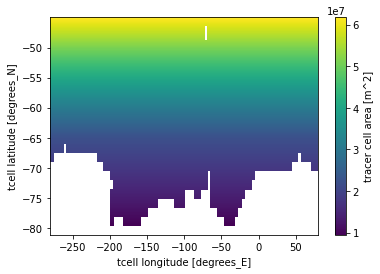

In [36]:
#Create weights with area
weights = SO_area
weights.name = 'weights'
weights.plot()

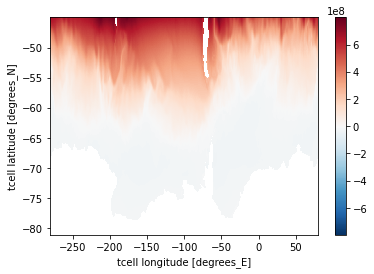

In [26]:
#Multiplying SST by area prior to mean calculations
SO_SST_weighted = SO_SST*weights

## Correcting longitude values in ACCESS-OM2-01 model outputs
Model outputs for ACCESS-OM2-01 range from -280 to +80, which causes problems with trying to perform spatial analyses on this data. To avoid issues, longitude values need to be corrected so they range between -180 and +180. This correction require several steps as there is no way to perform a simple conversion using `xr.assign_coords` or `xr.where`.

In [10]:
#First we make a deep copy of the longitude values to perform corrections
corr_lon = copy.deepcopy(SO_SST.xt_ocean.values)

#Now we need to correct any values smaller than -180 and replace them with values between +80 and +180. Note that the smallest longitude value (-279.95) should be +80.05.
#While -180.05 should have a correct value of +179.95.
corr_lon[np.where(corr_lon < -180)] = sorted(-corr_lon[np.where((corr_lon >= -180) & (corr_lon <= -80))])

#Checking corrected longitude values. The array should begin with +80.05 and increase to +179.95, after which we will have -180.05 increasing to +79.95.
corr_lon

array([80.05, 80.15, 80.25, ..., 79.75, 79.85, 79.95])

In [11]:
#We can now assign the corrected longitude values to the model outputs
SO_SST.coords['xt_ocean'] = corr_lon

#Prior to using this data array for plotting, it is necessary to sort the dataset by longitude
SO_SST = SO_SST.sortby(SO_SST.xt_ocean)

#Checking corrections to data array
SO_SST

,Array,Chunk
Bytes,7.80 GB,1.56 MB
Shape,"(732, 740, 3600)","(1, 540, 720)"
Count,60268 Tasks,8784 Chunks
Type,float32,numpy.ndarray


In [26]:
#One of the time steps can be saved as a netcdf file to correct data array longitudes faster
SO_SST[0].to_netcdf('SST_corrlon.nc')

## Correcting longitudes with an existing netcdf file

In [37]:
#If using a saved output, longitudes can be corrected with the following lines of code

#Load the netcdf file containing the corrected longitudes
corr_lon2 = xr.open_dataarray('SST_corrlon.nc')

#Assign them to xt_ocean (longitude) coordinates in the data array
weights.coords['xt_ocean'] = corr_lon2.xt_ocean.values

#Check results
weights

<xarray.DataArray 'weights' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

# Calculating zonal statistics on a data array using a shapefile

**Loading relevant libraries**

In [16]:
from rasterstats import zonal_stats
import rasterio
import geopandas
import rasterio.plot


import rioxarray
from shapely.geometry import mapping

**Indian Ocean**

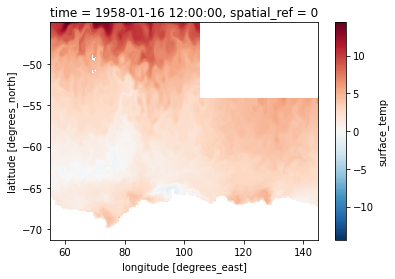

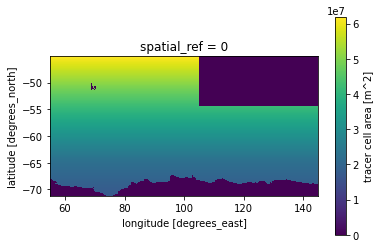

In [49]:
SO_SST.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
SO_SST.rio.write_crs("epsg:4326", inplace = True)

# SO_SST
IndianO = regions.query('SectorName == "Indian"')

clippedInd = SO_SST.rio.clip(IndianO.geometry.apply(mapping), IndianO.crs, drop = True)
clippedInd[0].plot()
IndianO.plot()


weights.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
weights.rio.write_crs("epsg:4326", inplace = True)
clippedWeights = weights.rio.clip(IndianO.geometry.apply(mapping), IndianO.crs, drop = True)
clippedWeights = clippedWeights.fillna(0)
clippedWeights.plot()

<AxesSubplot:title={'center':'time = 1958-01-16 12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

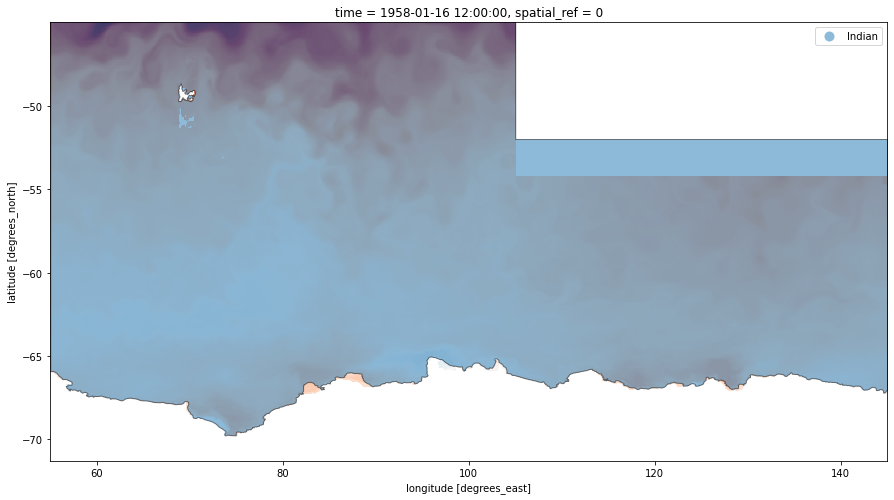

In [28]:
#Plot shapefile over the raster to ensure they both have the same projection
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
clippedInd[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
IndianO.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')


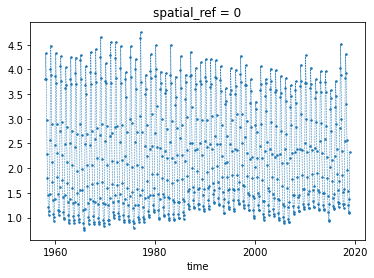

In [51]:
clippedInd_weighted = clippedInd.weighted(clippedWeights)
clippedInd_weighted
clippedInd_weighted_mean = clippedInd_weighted.mean(('xt_ocean', 'yt_ocean'))
clippedInd_weighted_mean.plot(linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

**East Pacific**

<AxesSubplot:title={'center':'time = 1958-01-16 12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

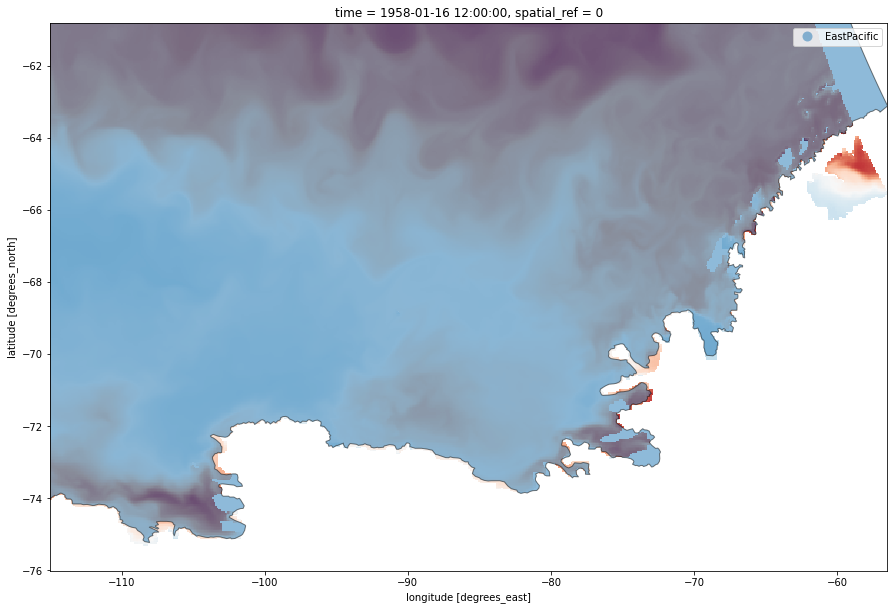

In [54]:
# SO_SST.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# SO_SST.rio.write_crs("epsg:4326", inplace = True)

# SO_SST
EastPac = regions.query('SectorName == "EastPacific"')

clippedEastPac = SO_SST.rio.clip(EastPac.geometry.apply(mapping), EastPac.crs, drop = True)
# clippedInd[0].plot()
# IndianO.plot()


# weights.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# weights.rio.write_crs("epsg:4326", inplace = True)
clippedWeightsEastPac = weights.rio.clip(EastPac.geometry.apply(mapping), EastPac.crs, drop = True)
clippedWeightsEastPac = clippedWeightsEastPac.fillna(0)
# clippedWeightsEastPac.plot()

#Plot shapefile over the raster to ensure they both have the same projection
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
clippedEastPac[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
EastPac.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

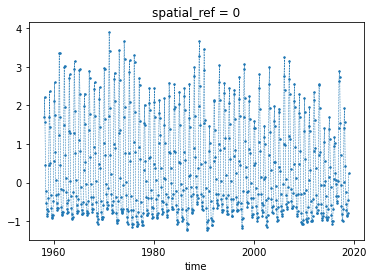

In [55]:
clippedEastPac_weighted = clippedEastPac.weighted(clippedWeightsEastPac)
clippedEastPac_weighted
clippedEastPac_weighted_mean = clippedEastPac_weighted.mean(('xt_ocean', 'yt_ocean'))
clippedEastPac_weighted_mean.plot(linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

**Atlantic region**

<AxesSubplot:title={'center':'time = 1958-01-16 12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

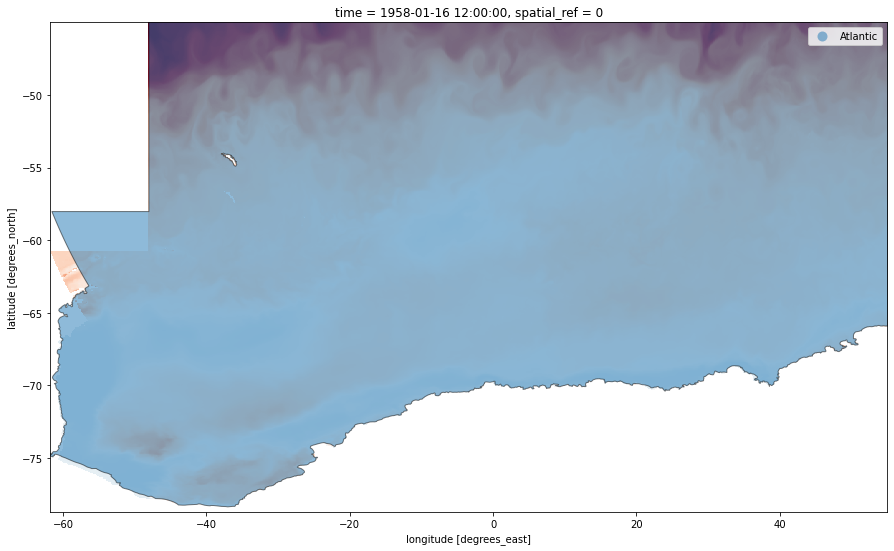

In [56]:
# SO_SST.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# SO_SST.rio.write_crs("epsg:4326", inplace = True)

# SO_SST
AtlO = regions.query('SectorName == "Atlantic"')

clippedAtlO = SO_SST.rio.clip(AtlO.geometry.apply(mapping), AtlO.crs, drop = True)
# clippedInd[0].plot()
# IndianO.plot()


# weights.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# weights.rio.write_crs("epsg:4326", inplace = True)
clippedWeightsAtlO = weights.rio.clip(AtlO.geometry.apply(mapping), AtlO.crs, drop = True)
clippedWeightsAtlO = clippedWeightsAtlO.fillna(0)
# clippedWeightsEastPac.plot()

#Plot shapefile over the raster to ensure they both have the same projection
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
clippedAtlO[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
AtlO.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

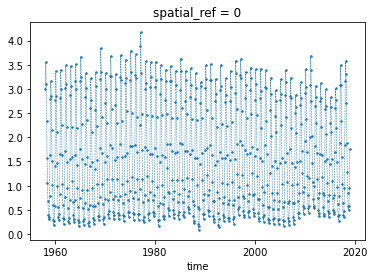

In [57]:
clippedAtlO_weighted = clippedAtlO.weighted(clippedWeightsAtlO)
clippedAtlO_weighted
clippedAtlO_weighted_mean = clippedAtlO_weighted.mean(('xt_ocean', 'yt_ocean'))
clippedAtlO_weighted_mean.plot(linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

**West Pacific**

<AxesSubplot:title={'center':'time = 1958-01-16 12:00:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

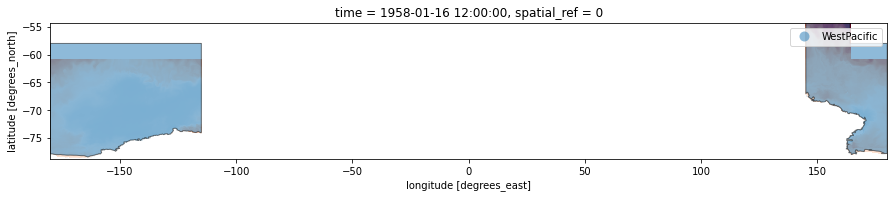

In [62]:
# SO_SST.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# SO_SST.rio.write_crs("epsg:4326", inplace = True)

# SO_SST
WP = regions.query('SectorName == "WestPacific"')

clippedWP = SO_SST.rio.clip(WP.geometry.apply(mapping), WP.crs, drop = True)
# clippedInd[0].plot()
# IndianO.plot()


# weights.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
# weights.rio.write_crs("epsg:4326", inplace = True)
clippedWeightsWP = weights.rio.clip(WP.geometry.apply(mapping), WP.crs, drop = True)
clippedWeightsWP = clippedWeightsWP.fillna(0)
# clippedWeightsEastPac.plot()

#Plot shapefile over the raster to ensure they both have the same projection
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
clippedWP[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
WP.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

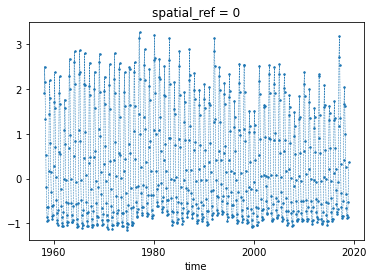

In [63]:
clippedWP_weighted = clippedWP.weighted(clippedWeightsWP)
clippedWP_weighted
clippedWP_weighted_mean = clippedWP_weighted.mean(('xt_ocean', 'yt_ocean'))
clippedWP_weighted_mean.plot(linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

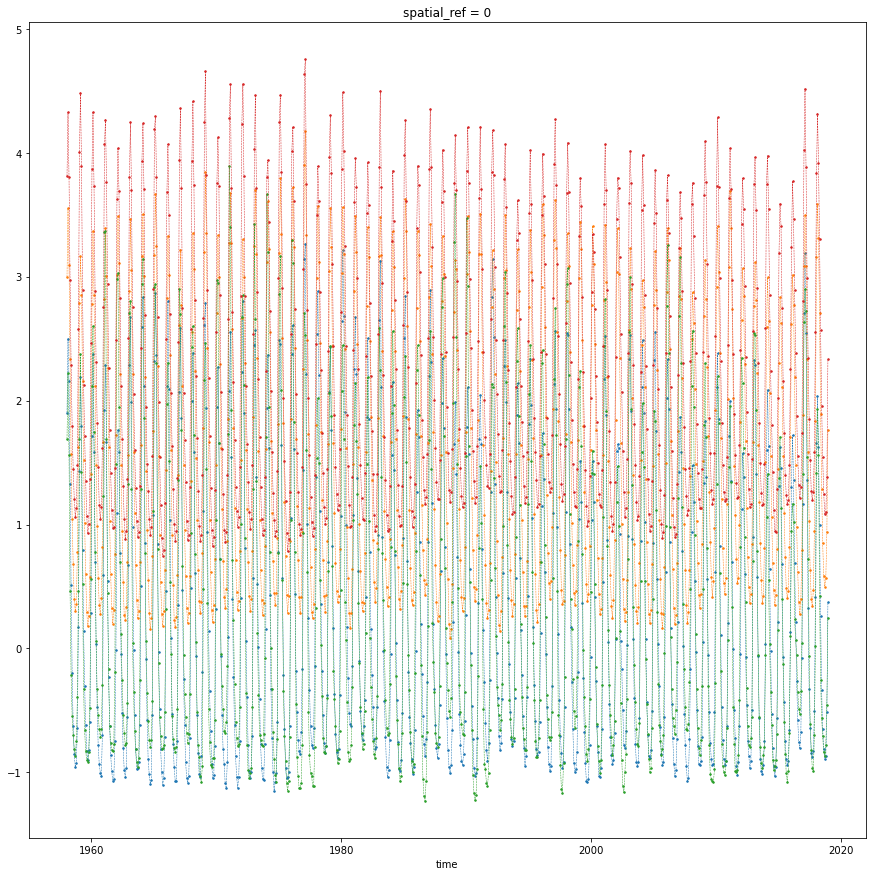

In [64]:
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
#Plot shapefile over the top and show each sector in different colour
clippedWP_weighted_mean.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)
clippedAtlO_weighted_mean.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)
clippedEastPac_weighted_mean.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)
clippedInd_weighted_mean.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

**Setting up supporting variables**

In [14]:
#In this step we will extract the affine information, which contains information about any transformations needed to be performed for the data to be presented as a map.
#Here the same file saved for correcting longitudes can be used
ncfile = 'SST_corrlon.nc'

#Loading the netcdf file as a raster
src = rasterio.open(f'netcdf:{ncfile}:{varInt}')

#Saving affine information
affine = src.transform

#Initialising variable that will contain zonal statistics
stats_list = []

#Getting the total number of time steps in zonal statistics input data
steps = SO_SST.shape[0]

**Loading shapefiles and extracting polygons of interest**  
The shapefiles used must have decimal degrees as units. If the shapefile has different units, it must reprojected prior to performing zonal statistics. To reproject a shapefile use the following line of code `reproj_shp = shp.to_crs({'init': 'epsg:4326'})`, where `shp` is the name of the shapefile being reprojected. In this case, the shapefile was reprojected to WGS84, which has an EPSG code of 4326.

Note subsetting of the shapefile may not always be required. This is an optional step.

In [15]:
#Access shapefile with boundaries of interest
regions = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/ACE_ecostasts/aes_polar_regions_simple_wgs84.shp')
regions

# #Subset the shapefile if necessary. In this case, polygons in the temperate zones are excluded
# AntSub = regions.query('Zone != "Temperate"')
# #Check resulting shapefile
# AntSub

,SectorName,Zone,area_km2,colour,geometry
0,Indian,Polar,1.240618e+07,#00BFC499,"POLYGON ((145.00000 -65.93236, 145.00000 -67.0..."
1,WestPacific,Polar,9.022348e+06,#F8766DFF,"MULTIPOLYGON (((-180.00000 -71.57423, -180.000..."
2,EastPacific,Polar,3.966731e+06,#C77CFFFF,"POLYGON ((-58.36516 -61.47690, -58.30158 -61.5..."
3,Atlantic,Polar,2.094065e+07,#7CAE00FF,"POLYGON ((-57.00803 -63.29530, -56.96140 -63.2..."


<AxesSubplot:>

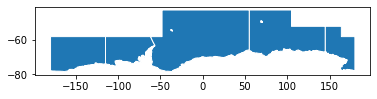

In [32]:
#Plot the shapefile
regions.plot(edgecolor = 'white')

**Final check of data prior to calculation of zonal statistics**

<AxesSubplot:title={'center':'time = 1958-01-16 12:00:00'}, xlabel='xt_ocean', ylabel='tcell latitude [degrees_N]'>

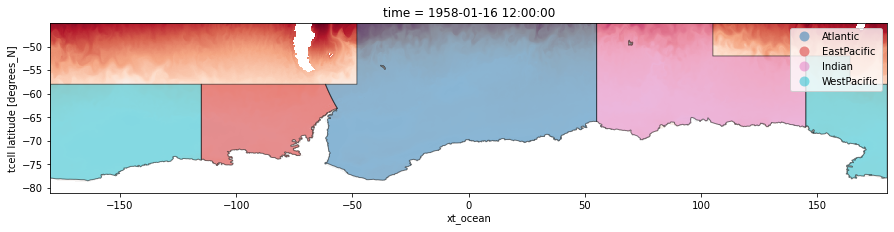

In [33]:
#Plot shapefile over the raster to ensure they both have the same projection
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Use first time step of data array
SO_SST_weighted[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

**Calculating zonal statistics**

In [34]:
for i in np.arange(0, steps):
    stats_list.append(pd.DataFrame(zonal_stats(regions, SO_SST_weighted[i].values, affine = affine, stats = ['count', 'mean', 'std'])))
df_stats = pd.concat(stats_list, keys = [str(t).split(' ')[0] for t in SO_SST_weighted.time.values])

print(df_stats)

                      mean   count           std
1958-01-16 0  4.049753e+07   99771  2.797063e+07
           1  1.214332e+08  339596  1.594043e+08
           2  8.789533e+07  148493  8.999579e+07
           3  3.936121e+07  372234  6.579446e+07
1958-02-15 0  4.057373e+07   99771  2.270704e+07
...                    ...     ...           ...
2018-11-16 3 -2.051396e+07  372234  4.850718e+07
2018-12-16 0 -8.837797e+06   99771  2.220121e+07
           1  8.420613e+07  339596  1.555304e+08
           2  5.516566e+07  148493  8.409296e+07
           3 -5.111927e+05  372234  5.966177e+07

[2928 rows x 3 columns]


In [35]:
#Calculating standard error
df_stats['std_e'] = df_stats['std']/np.sqrt(df_stats['count'])

#Save mean and standard error as data array
xr_stats = df_stats[['mean', 'std_e']].to_xarray()
xr_stats = xr_stats.rename(({'level_0':'time', 'level_1':'sector'}))
xr_stats.coords['sector'] = regions.SectorName.values
xr_stats.coords['time'] = SO_SST.time.values
xr_stats

<xarray.Dataset>
Dimensions:  (sector: 4, time: 732)
Coordinates:
  * time     (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * sector   (sector) object 'Indian' 'WestPacific' 'EastPacific' 'Atlantic'
Data variables:
    mean     (time, sector) float64 4.05e+07 1.214e+08 ... 5.517e+07 -5.112e+05
    std_e    (time, sector) float64 8.855e+04 2.735e+05 ... 2.182e+05 9.779e+04

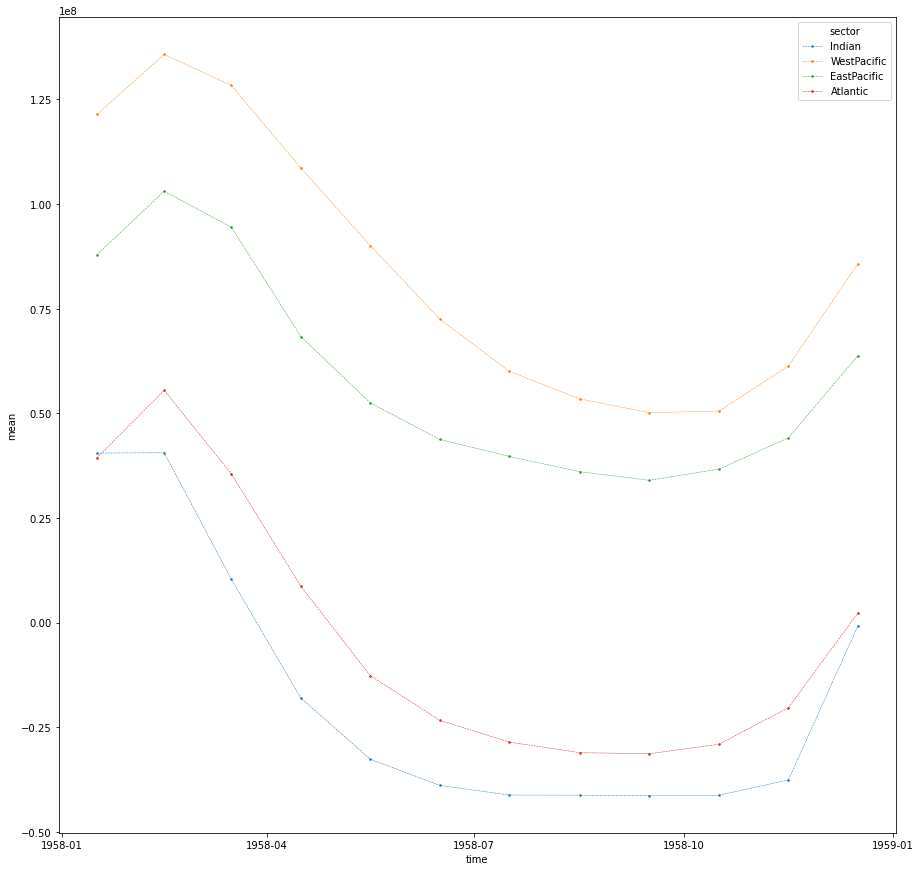

In [36]:
plt.subplots(figsize = (15, 15))
xr_stats['mean'].sel(time = '1958').plot(hue = 'sector', linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)
# xr_stats['mean'].plot(col = 'sector', col_wrap = 2, linestyle='dashed',color='g', linewidth=0.5, marker='o', markersize=1)

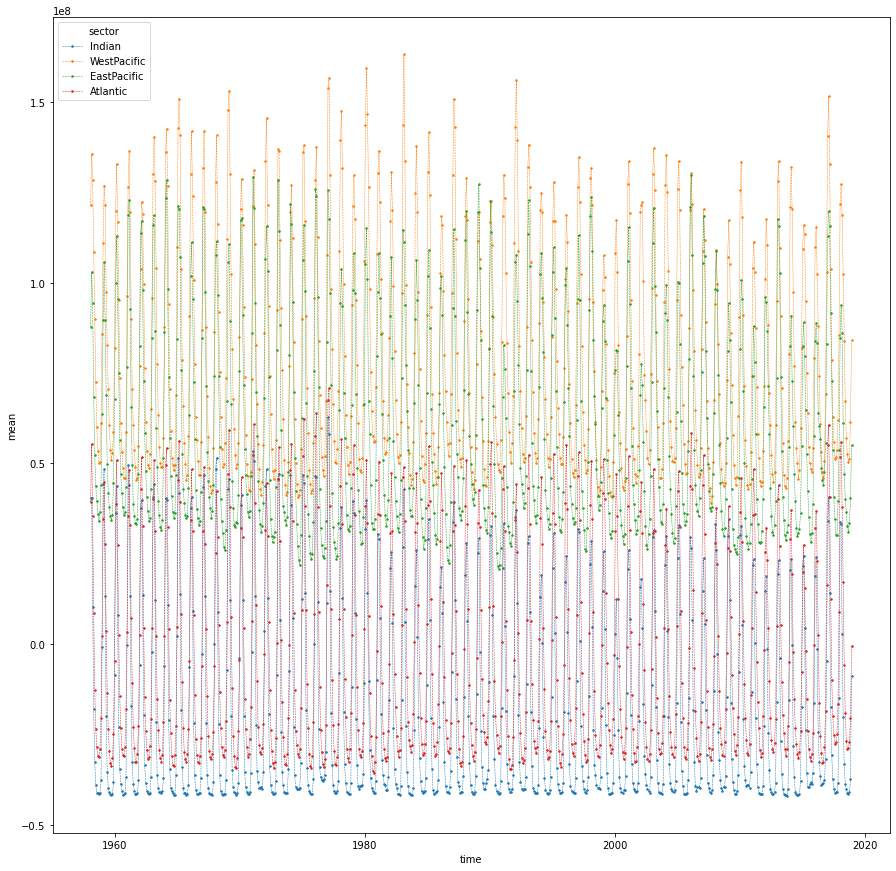

In [37]:
plt.subplots(figsize = (15, 15))
xr_stats['mean'].plot(hue = 'sector', linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

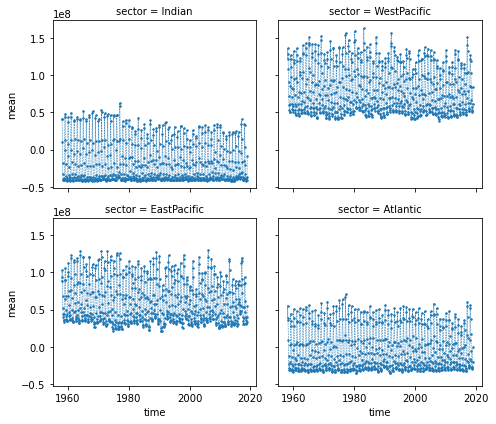

In [41]:
xr_stats['mean'].plot(col = 'sector', col_wrap = 2, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

In [68]:
#Calculate zonal statistics
# stats = zonal_stats(AntSub, SO_SST[0].values, affine = affine, stats = ['sum', 'count', 'mean'], geojson_out = True)
stats[0]['properties']
# stats_list.append(pd.DataFrame(zonal_stats("/g/data/v45/la6889/GIS_DataBase/Shapefiles/SO_reproj.shp", SO_SST[0].values, affine=affine)))
# SO_SST[0].transform
# stats_list
# print(src.crs)
# print(src.driver)
# AntSub.crs
# x.to_netcdf('test.nc')

{'BathyClass': 'Continent',
 'Name': 'WestPacific_Polar_Continent',
 'SectorName': 'WestPacific',
 'Shelf': 'Shelf',
 'Zone': 'Polar',
 'area_km2': 885409.0019584384,
 'colour': '#F8766DFF',
 'mean': 8.318479284817201,
 'count': 52433,
 'sum': 436162.8243408203}

In [77]:
for i in np.arange(0, len(stats)):
    print(stats[i]['properties'])

{'BathyClass': 'Continent', 'Name': 'WestPacific_Polar_Continent', 'SectorName': 'WestPacific', 'Shelf': 'Shelf', 'Zone': 'Polar', 'area_km2': 885409.0019584384, 'colour': '#F8766DFF', 'mean': 8.318479284817201, 'count': 52433, 'sum': 436162.8243408203}
{'BathyClass': 'BanksPlateaus', 'Name': 'Indian_Polar_BanksPlateaus', 'SectorName': 'Indian', 'Shelf': 'Ocean', 'Zone': 'Polar', 'area_km2': 676845.5655495276, 'colour': '#00BFC499', 'mean': 1.862314927352023, 'count': 71014, 'sum': 132250.43225097656}
{'BathyClass': 'Continent', 'Name': 'Atlantic_Polar_Continent', 'SectorName': 'Atlantic', 'Shelf': 'Shelf', 'Zone': 'Polar', 'area_km2': 1084547.9527957034, 'colour': '#7CAE00FF', 'mean': 3.405710260563036, 'count': 55666, 'sum': 189582.26736450195}
{'BathyClass': 'Continent', 'Name': 'Indian_Polar_Continent', 'SectorName': 'Indian', 'Shelf': 'Shelf', 'Zone': 'Polar', 'area_km2': 706453.8107089174, 'colour': '#00BFC4FF', 'mean': 1.5983089485888762, 'count': 28757, 'sum': 45962.57043457031

In [120]:
# print(x.shape)
# d = np.array([stats[0]['properties']['Name'], stats[0]['properties']['sum'], stats[0]['properties']['count'], stats[0]['properties']['mean']])
# print(d.shape)
# np.stack((x, d))
# for i in np.arange(0, len(stats)):
#     d = np.array([stats[i]['properties']['Name'], stats[i]['properties']['sum'], stats[i]['properties']['count'], stats[i]['properties']['mean']])
#     np.concatenate((x, d), axis = 0)
# d
# pd.DataFrame(np.array([[stats[0]['properties']['Name']], [stats[0]['properties']['sum']], [stats[0]['properties']['count']], [stats[0]['properties']['mean']]]))#, columns = ['name', 'sum', 'count', 'mean'])
# d = {'Name': stats[0]['properties']['Name'], 'sum': stats[0]['properties']['sum'], 'count': stats[0]['properties']['count'], 'mean': stats[0]['properties']['mean']}
# pd.DataFrame(data = d)
# print(np.array([[stats[0]['properties']['Name']], [stats[0]['properties']['sum']], [stats[0]['properties']['count']], [stats[0]['properties']['mean']]]))
# print(np.array([stats[0]['properties']['Name'], stats[0]['properties']['sum'], stats[0]['properties']['count'], stats[0]['properties']['mean']]))

ValueError: all input arrays must have the same shape

In [48]:
rastats = zonal_stats(AntSub, SO_SST[0].values, affine = affine, stats = ['sum', 'count', 'mean'], raster_out = True)
rastats[0].plot()

AttributeError: 'dict' object has no attribute 'plot'